In [66]:
# load json file as dictionary
import json
import sys
import pandas as pd
import numpy as np
import re
import seaborn as sns

from umap import UMAP
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
import bertopic
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech
from bertopic.vectorizers import ClassTfidfTransformer
import datamapplot
import nbformat
from sklearn.feature_extraction import text 



In [58]:
patents_text = pd.read_csv("patents_text_topic_modelling2.csv")

/var/folders/jy/j77v476x03737ryp7gll_0p00000gn/T/ipykernel_23498/3127923996.py:1: DtypeWarning: Columns (18,20,21,23,49,50) have mixed types. Specify dtype option on import or set low_memory=False.
  patents_text = pd.read_csv("patents_text_topic_modelling2.csv")


In [59]:
patents_text['title'] = patents_text['title'].fillna('')
patents_text['abstract'] = patents_text['abstract'].fillna('')
patents_text['description'] = patents_text['description'].fillna('')
patents_text['claims'] = patents_text['claims'].fillna('')

## Sustainability of AI

In [25]:
sofai = patents_text[(patents_text['SofAI'] == 1) & (patents_text['AIforS'] == 0)]

def extract_first_300_words(text):
    words = re.findall(r'\b\w+\b', text)
    return ' '.join(words[:300])
abstracts = sofai['title'] + sofai['abstract'] + sofai["description"].fillna('').apply(extract_first_300_words)
abstracts = abstracts.apply(str).tolist()

In [26]:
patents_text['text'] = patents_text['title'] + patents_text['abstract'] + patents_text["description"].fillna('').apply(extract_first_300_words)

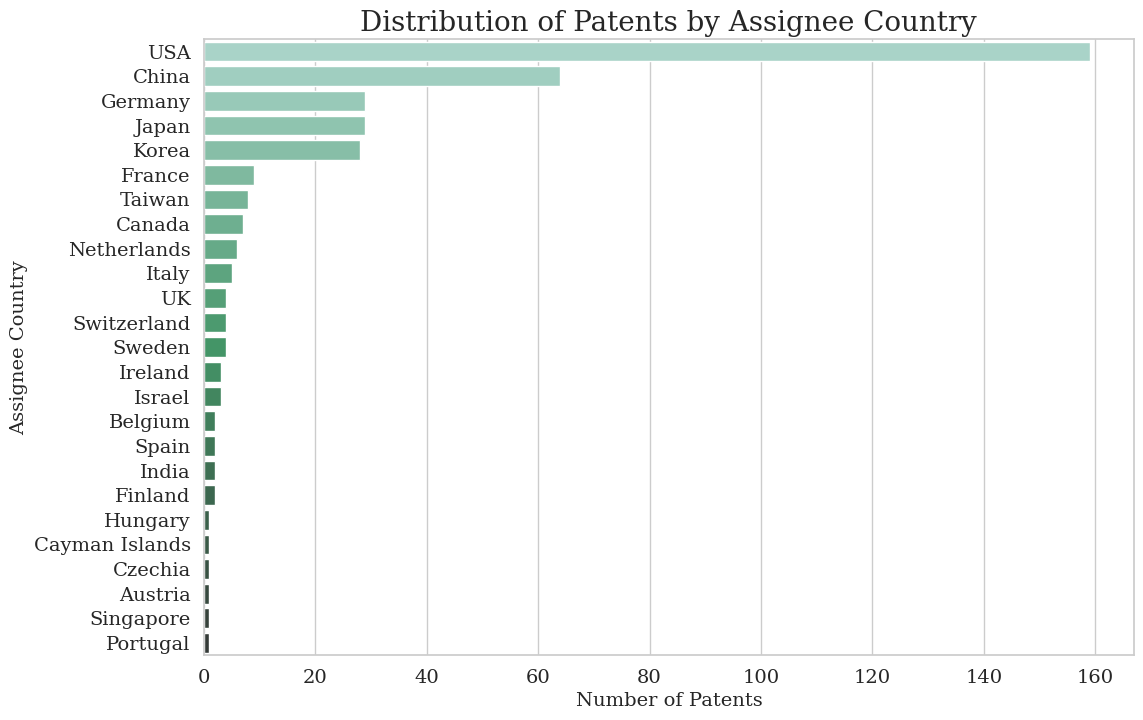

In [136]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from iso3166 import countries

# Assuming 'sofai' is your filtered dataframe

# Create a dictionary to map two-letter country codes to full names
country_dict = {country.alpha2: country.name for country in countries}

# Map the country codes to full names
sofai['assignee_country_full'] = sofai['assignee_country'].map(country_dict)

custom_labels = {
    'United States of America': 'USA',
    'United Kingdom of Great Britain and Northern Ireland': 'UK',
    'Korea, Republic of': 'Korea',
    'Taiwan, Province of China': 'Taiwan'
}
# Apply the custom labels
sofai['assignee_country_full'] = sofai['assignee_country_full'].replace(custom_labels)


# Count the number of patents by full country name
country_counts = sofai['assignee_country_full'].value_counts().sort_values(ascending=False)
# Create a color palette and reverse the order
palette = sns.color_palette('BuGn_d', len(country_counts))

# Create the plot
plt.figure(figsize=(12, 8))
sns.barplot(y=country_counts.index, x=country_counts.values, palette=palette)

# Set titles and labels
plt.title('Distribution of Patents by Assignee Country')
plt.xlabel('Number of Patents')
plt.ylabel('Assignee Country')

# Show the plot
plt.show()


In [45]:
len(abstracts)

548

In [60]:
# Load embeddings
# pre-calculated to improve efficiency
embeddings_specter = np.load('embeddings_specter_sofai.npy')

In [61]:
# prevent stochastic behaviour
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

# control number of topics
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# improve representation by preprocessing topic representations after documents are assigned
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))
vectorizer_model2 = CountVectorizer(stop_words=text.ENGLISH_STOP_WORDS.union(np.array(["method", "device", "apparatus", "system", "invention"])), min_df=2, ngram_range=(1, 2))
# use additional representations
# KeyBERT
keybert_model = KeyBERTInspired()

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# All representation models
representation_model = {
    "KeyBERT": keybert_model,
    "MMR": mmr_model
}

# embedding model
embedding_model_specter = SentenceTransformer("sentence-transformers/allenai-specter", revision=None)


## Zero shot modelling

In [62]:
stopwords_list = [
    "a", "needn", "a", "not", "able", "never",
    "about", "needn't", "accordance", "now", "above-", "often",
    "above", "no", "according", "of", "mentioned", "others",
    "after", "nor", "all", "on", "accordingly", "otherwise",
    "again", "not", "an", "or", "along", "rather",
    "ain", "o", "and", "other", "already", "remarkably",
    "all", "of", "another", "particularly", "alternatively", "significantly",
    "am", "off", "are", "preferably", "always", "simply",
    "an", "on", "as", "preferred", "among", "sometimes",
    "and", "once", "at", "present", "and/or", "specifically",
    "any", "only", "be", "provide", "anything", "straight",
    "are", "or", "because", "provided", "anywhere", "forward",
    "aren", "other", "been", "provides", "better", "substantially",
    "aren't", "our", "being", "relatively", "disclosure", "thereafter",
    "as", "ours", "by", "respectively", "due", "therebetween",
    "at", "ourselves", "claim", "said", "easily", "therefor",
    "be", "out", "comprises", "should", "easy", "therefrom",
    "because", "over", "corresponding", "since", "e.g", "therein",
    "been", "own", "could", "some", "either", "thereinto",
    "before", "re", "described", "such", "elsewhere", "thereon",
    "being", "s", "desired", "suitable", "enough", "therethrough",
    "below", "same", "do", "than", "especially", "therewith",
    "between", "shan", "does", "that", "essentially", "together",
    "both", "shan't", "each", "the", "et al", "toward",
    "but", "she", "embodiment", "their", "etc", "towards",
    "by", "she's", "fig", "then", "eventually", "typical",
    "can", "should", "figs", "there", "excellent", "upon",
    "couldn", "should've", "for", "thereby", "finally", "via",
    "couldn't", "shouldn", "from", "therefore", "furthermore", "vice versa",
    "d", "shouldn't", "further", "thereof", "good", "whatever",
    "did", "so", "generally", "thereto", "hence", "whereas",
    "didn", "some", "had", "these", "he/she", "whereat",
    "didn't", "such", "has", "they", "him/her", "wherever",
    "do", "t", "have", "this", "his/her", "whether",
    "does", "than", "having", "those", "ie", "whose",
    "doesn", "that", "herein", "thus", "ii", "within",
    "doesn't", "that'll", "however", "to", "iii", "without",
    "doing", "the", "if", "use", "instead", "yet",
    "don", "their", "in", "various", "later",
    "don't", "theirs", "into", "was", "like",
    "down", "them", "invention", "were", "little",
    "during", "themselves", "is", "what", "many",
    "each", "there", "it", "when", "may",
    "few", "these", "its", "where", "meanwhile",
    "for", "they", "means", "whereby", "might",
    "from", "this", "wherein", "moreover",
    "further", "those", "which", "much",
    "had", "through", "while", "must",
    "hadn", "to", "who",
    "hadn't", "too", "will",
    "has", "under", "with",
    "hasn", "until", "would",
    "hasn't", "up",
    "have", "ve",
    "haven", "very",
    "haven't", "was",
    "having", "wasn",
    "he", "wasn't",
    "her", "we",
    "here", "were",
    "hers", "weren",
    "herself", "weren't",
    "him", "what",
    "himself", "when",
    "his", "where",
    "how", "which",
    "i", "while",
    "if", "who",
    "in", "whom",
    "into", "why",
    "is", "will",
    "isn", "with",
    "isn't", "won",
    "it", "won't",
    "it's", "wouldn",
    "its", "wouldn't",
    "itself", "y",
    "just", "you",
    "ll", "you'd",
    "m", "you'll",
    "ma", "you're",
    "me", "you've",
    "mightn", "your",
    "mightn't", "yours",
    "more", "yourself",
    "most", "yourselves",
    "mustn",
    "mustn't",
    "my",
    "myself", "method", "system", "apparatus"
]


## 1 Operational view: 

Data:
- Data collection

AI operations:
- Model
- Infrastructure
    - Storage
    - Network
    - General hardware (e.g., Data center)
- Platform
- Specialised Hardware

In [98]:
vectorizer_model2 = CountVectorizer(stop_words=stopwords_list, ngram_range=(1, 2))

#zeroshot_topic_list = ["data acquisition and sensor technology", "data storage", "algorithmic design, layers, model", "computing hardware", "deployment, edge and cloud"]
#zeroshot_topic_list = ["sensor data collection, environmental monitoring, IoT sensors", "data storage, data warehouses, data management, data center, uninterruptible power supply, power factor correction, power transfer", "algorithmic design, model architecture, layer, deep learning, weights", "computing hardware, processors, GPU, cooling, memory", "power management, battery", "network infrastructure, bandwidth, data transmission", "deployment, edge and cloud"]
zeroshot_topic_list = [
    "sensor, data collection, environmental monitoring, IoT sensors", # data collection
    "storage, storage area network, network-attached storage, distributed file system" , # data storage
    "data center, uninterruptible power supply, power distribution unit, generator, cooling, ventilation, pump, chiller, low-precision hardware", # general data center infrastructure
    "algorithmic design, weights, pruned, parallelism, model compression", # model development
    "computation, specialized acceleration, application-specific integrated circuits, field-programmable gate array", # compute
    "network infrastructure, bandwidth, data transmission, routers, cable, switch, firewall, connectivity", # network
    "platform for optimization techniques, framework, library"
    #"deployment, edge and cloud, inference, inference prediction, production use case" # deployment
    ]

           
topic_model = BERTopic(embedding_model=embedding_model_specter, 
    min_topic_size=10,
    zeroshot_topic_list=zeroshot_topic_list,
    zeroshot_min_similarity=.57,
    vectorizer_model = vectorizer_model2,
    representation_model= representation_model
    #ctfidf_model=ctfidf_model
    )

# Train model
topics, probs = topic_model.fit_transform(abstracts, embeddings_specter)

# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,MMR,Representative_Docs
0,0,167,"computation, specialized acceleration, applica...","[data, processing, one, memory, instruction, u...","[accelerator, hardware, processor, cores, comp...","[data, processing, one, memory, instruction, u...",[compute optimization mechanism for deep neura...
1,1,121,"data center, uninterruptible power supply, pow...","[power, first, second, input, signal, mode, de...","[power supply, power saving, power consumption...","[power, first, second, input, signal, mode, de...",[power supply a factorized power architecture ...
2,2,75,"sensor, data collection, environmental monitor...","[model, image, device, one, first, feature, in...","[mobile device, device, computing device, appl...","[model, image, device, one, first, feature, in...",[voice actions on computing devices a computer...
3,3,67,"storage, storage area network, network-attache...","[data, storage, information, unit, moving, exa...","[disk drive, storage, data storage, devices, d...","[data, storage, information, unit, moving, exa...",[methods and apparatus for sparse tensor stora...
4,4,64,"algorithmic design, weights, pruned, paralleli...","[graphics, one, processor, data, processing, e...","[graphics processor, gpgpu, graphics processin...","[graphics, one, processor, data, processing, e...",[machine learning sparse computation mechanism...
5,5,29,"platform for optimization techniques, framewor...","[application, optimization, example, applicati...","[resource scheduling, application data, deploy...","[application, optimization, example, applicati...","[resource scheduling method and apparatus, dev..."
6,6,25,"network infrastructure, bandwidth, data transm...","[code, first, service, bandwidth, time, sound,...","[network device, device, network, service flow...","[code, first, service, bandwidth, time, sound,...",[method for the digital evaluation of a data t...


In [101]:
timestamps = pd.to_datetime(sofai['publication_date_EPO'], format='%Y%m%d').to_list()
topics_over_time = topic_model.topics_over_time(abstracts, timestamps, nr_bins=20)
# or use one of the other topic representations, like KeyBERTInspired
topic_model.set_topic_labels({0: "Specialised hardware", 1: "General hardware", 2: "Data collection", 3: "Storage", 4: "Model", 5: "Platform", 6: "Network"})

topic_model.visualize_topics_over_time(topics_over_time, custom_labels=True)

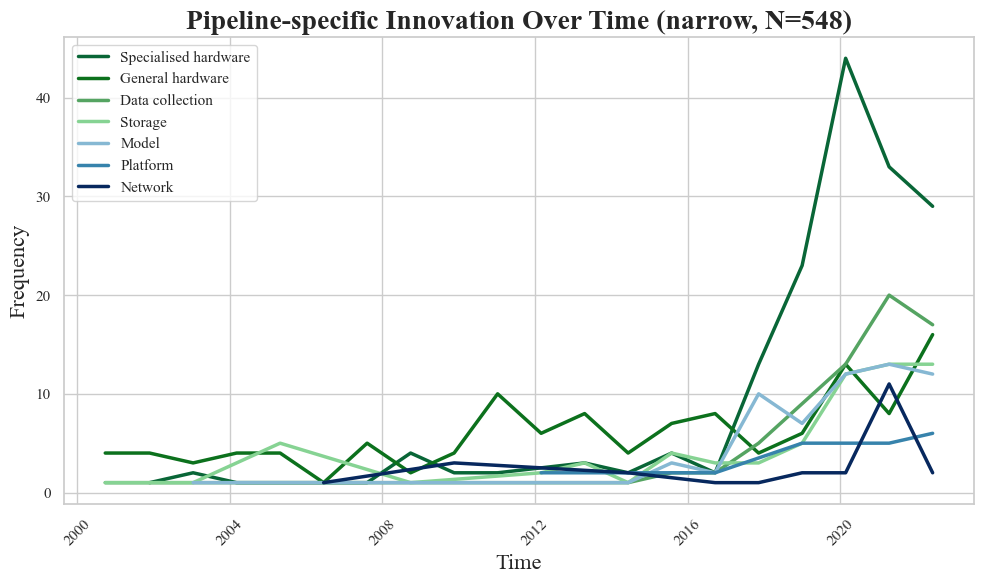

In [103]:
# Setting the topic labels
topic_labels = {0: "Specialised hardware", 1: "General hardware", 2: "Data collection", 3: "Storage", 4: "Model", 5: "Platform", 6: "Network"}

## Pivot the DataFrame to get the topics as columns
topics_pivot = topics_over_time.pivot(index='Timestamp', columns='Topic', values='Frequency')

# Set the style for the plot
sns.set(style="whitegrid")

# Create a color palette with shades of Seagreen
colours = {
    0: '#096637',
    1: '#0c711d',
    2: '#55a462',
    3: '#86d393',
    4: '#86b8d3',
    5: '#3783ac',
    6: '#07285e'
}
 # 7 colors for the 7 topics

# Plotting with Seaborn
plt.figure(figsize=(10, 6))

# Loop through each topic and plot it
for idx, topic in enumerate(topics_pivot.columns):
    sns.lineplot(data=topics_pivot, x=topics_pivot.index, y=topic, label=topic_labels[topic], color=colours[idx], linewidth=2.5)

# Customize the plot for a scientific paper look
plt.title('Pipeline-specific Innovation Over Time (narrow, N=548)', fontsize=20, fontweight='bold', fontname='Times New Roman')
plt.xlabel('Time', fontsize=16, fontname='Times New Roman')
plt.ylabel('Frequency', fontsize=16, fontname='Times New Roman')
plt.xticks(rotation=45, fontname='Times New Roman')
plt.yticks(fontname='Times New Roman')
plt.legend(fontsize='16', prop={'family': 'Times New Roman'})
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

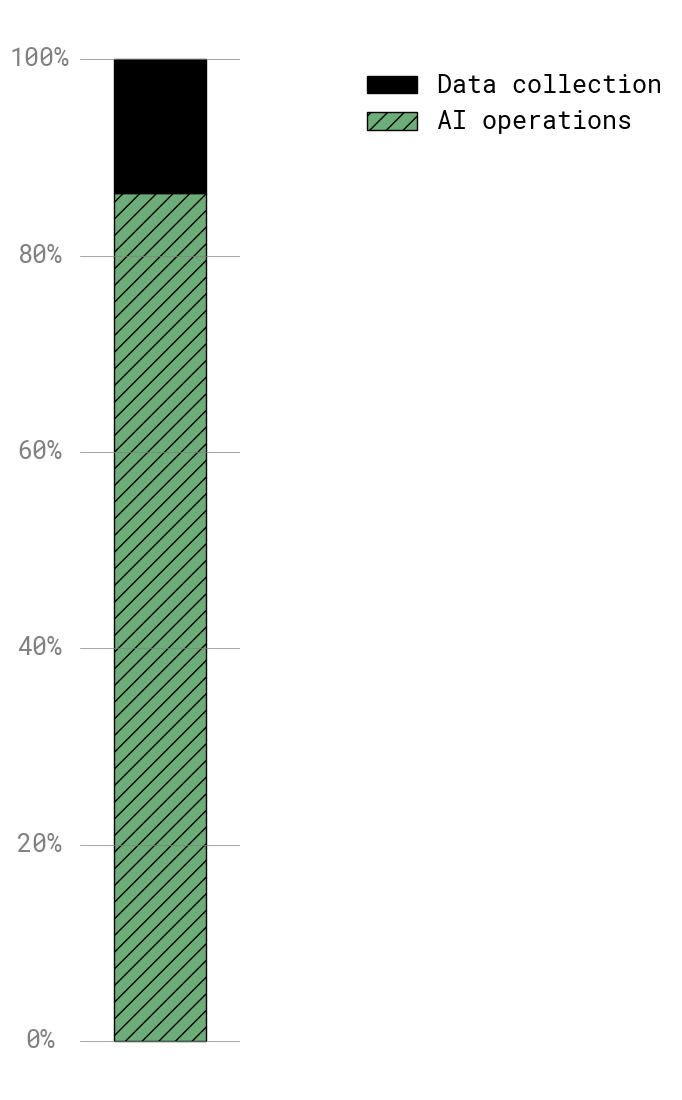

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.font_manager as font_manager
# Ensure LaTeX is not used
plt.rcParams['text.usetex'] = False
font_path = '/Library/Fonts/RobotoMono-Regular.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=18)


# Data
topics = [
    "Data collection",
    "AI operations"
]


counts = [75, 548-75]

# Create a DataFrame
df = pd.DataFrame({
    'Topic': topics,
    'Count': counts
})

# Normalize the counts to percentages
total = sum(df['Count'])
df['Percentage'] = (df['Count'] / total) * 100

# Sort the DataFrame by 'Count' in descending order
df = df.sort_values(by='Count', ascending=False).reset_index(drop=True)

# Initialize the plot
fig, ax = plt.subplots(figsize=(4, 12))

# Add a light grey grid in the background
ax.set_facecolor('lightgrey')
ax.grid(which='major', axis='y', linestyle='--', color='white')

# Define colors and hatches
colors = ['#6bae77', '#000000']
hatches = ['//', None]

# Plotting the single bar with segments
bottom = 0.01
for i, (percentage, color, hatch) in enumerate(zip(df['Percentage'], colors, hatches)):
    ax.bar(['AI pipeline'], percentage, bottom=bottom, color=color, edgecolor='black', hatch=hatch)
    bottom += percentage

# Adding horizontal lines at every 20%
for i in range(0, 101, 20):
    ax.axhline(y=i, color='grey', linestyle='-', linewidth=0.5)
    ax.text(-1.05, i, f'{i}%', ha='center', va='center', color='grey', fontsize=18, fontproperties=font_prop)  # Adding the percentage labels

ax.set_xlim(-0.7, 0.7)
legend_labels = df['Topic'][::-1]  # Reverse the order of labels
legend_colors = colors[:len(df)][::-1]  # Reverse the order of colors
legend_hatches = hatches[:len(df)][::-1] 

# Create custom legend handles
handles = []
for color, hatch, label in zip(legend_colors, legend_hatches, legend_labels):
    patch = plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black', hatch=hatch, label=label)
    handles.append(patch)
legend = ax.legend(handles=handles, loc='upper right', bbox_to_anchor=(3.7, 0.95), borderaxespad=0, frameon=False, fontsize=18)
for text in legend.get_texts():
    text.set_fontproperties(font_prop)
# Adding grid and labels
ax.set_yticks(range(0, 101, 20))
ax.set_yticklabels([f'{i}%' for i in range(0, 101, 20)], fontproperties=font_prop)

# Removing axes for cleaner look
ax.axis('off')

# Adjusting the plot layout to avoid overlap
plt.subplots_adjust(left=0.35, right=0.75, top=0.95, bottom=0.05)

# Display the plot
plt.show()

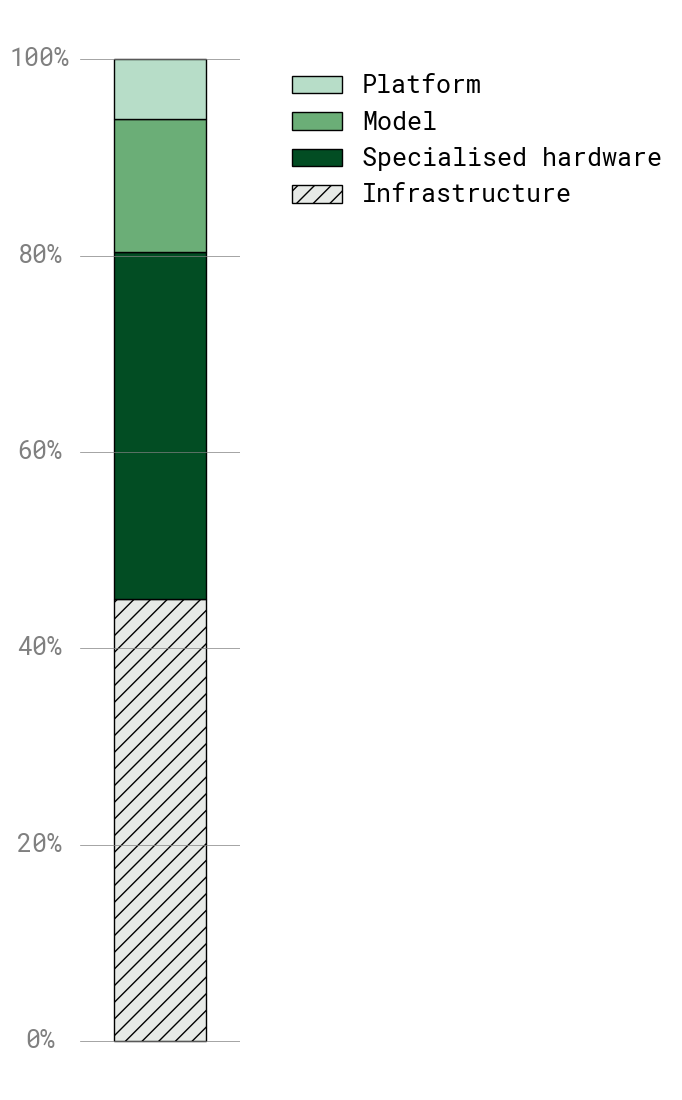

In [10]:
# Ensure LaTeX is not used
plt.rcParams['text.usetex'] = False
font_path = '/Library/Fonts/RobotoMono-Regular.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=18)


# Data
topics = [
    "Model",
    "Platform",
    "Specialised hardware",
    "Infrastructure"
]


counts = [64, 29, 167, 121+67+25]

# Create a DataFrame
df = pd.DataFrame({
    'Topic': topics,
    'Count': counts
})

# Normalize the counts to percentages
total = sum(df['Count'])
df['Percentage'] = (df['Count'] / total) * 100

# Sort the DataFrame by 'Count' in descending order
df = df.sort_values(by='Count', ascending=False).reset_index(drop=True)


# Initialize the plot
fig, ax = plt.subplots(figsize=(4, 12))

# Add a light grey grid in the background
ax.set_facecolor('lightgrey')
ax.grid(which='major', axis='y', linestyle='--', color='white')

# Define colors and hatches
colors = ['#e7eae7',
          '#024d23', 
          '#6bae77',
          '#b7ddc8'
          ]
hatches = ['//', None, None, None]

# Plotting the single bar with segments
bottom = 0.01
for i, (percentage, color, hatch) in enumerate(zip(df['Percentage'], colors, hatches)):
    ax.bar(['AI pipeline'], percentage, bottom=bottom, color=color, edgecolor='black', hatch=hatch)
    bottom += percentage

# Adding horizontal lines at every 20%
for i in range(0, 101, 20):
    ax.axhline(y=i, color='grey', linestyle='-', linewidth=0.5)
    ax.text(-1.05, i, f'{i}%', ha='center', va='center', color='grey', fontsize=18, fontproperties=font_prop)  # Adding the percentage labels

ax.set_xlim(-0.7, 0.7)
legend_labels = df['Topic'][::-1]  # Reverse the order of labels
legend_colors = colors[:len(df)][::-1]  # Reverse the order of colors
legend_hatches = hatches[:len(df)][::-1] 

# Create custom legend handles
handles = []
for color, hatch, label in zip(legend_colors, legend_hatches, legend_labels):
    patch = plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black', hatch=hatch, label=label)
    handles.append(patch)
legend=ax.legend(handles=handles, loc='upper right', bbox_to_anchor=(3.7, 0.95), borderaxespad=0, frameon=False, fontsize=18)
for text in legend.get_texts():
    text.set_fontproperties(font_prop)
# Adding grid and labels
ax.set_yticks(range(0, 101, 20))
ax.set_yticklabels([f'{i}%' for i in range(0, 101, 20)], fontproperties=font_prop)

# Removing axes for cleaner look
ax.axis('off')

# Adjusting the plot layout to avoid overlap
plt.subplots_adjust(left=0.35, right=0.75, top=0.95, bottom=0.05)

# Display the plot
plt.show()



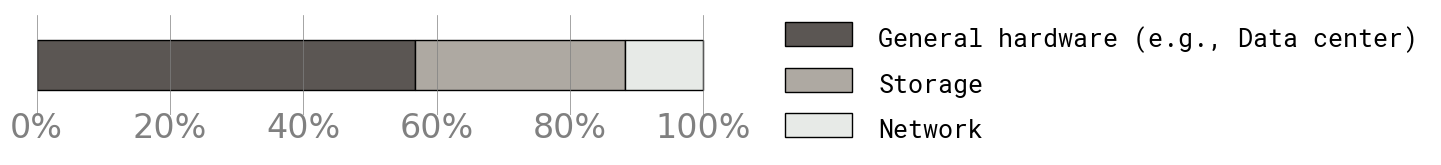

In [6]:
# Data
topics = [
    "Storage",
    "Network",
    "General hardware (e.g., Data center)"
]


counts = [67, 25, 121]

# Create a DataFrame
df = pd.DataFrame({
    'Topic': topics,
    'Count': counts
})

# Normalize the counts to percentages
total = sum(df['Count'])
df['Percentage'] = (df['Count'] / total) * 100

# Sort the DataFrame by 'Count' in descending order
df = df.sort_values(by='Count', ascending=False).reset_index(drop=True)

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 2))

# Add a light grey grid in the background
ax.set_facecolor('lightgrey')
ax.grid(which='major', axis='x', linestyle='--', color='white')

# Define colors and hatches
colors = ['#5b5653', '#aea9a2', '#e7eae7']
hatches = [None, None, None]

# Plotting the single bar with segments
left = 0
for i, (percentage, color, hatch) in enumerate(zip(df['Percentage'], colors, hatches)):
    ax.barh(['AI pipeline'], percentage, left=left, color=color, edgecolor='black', hatch=hatch)
    left += percentage

# Adding vertical lines at every 20%
for i in range(0, 101, 20):
    ax.axvline(x=i, color='grey', linestyle='-', linewidth=0.5)
    ax.text(i, -1, f'{i}%', ha='center', va='center', color='grey', fontsize=24)  # Adding the percentage labels

ax.set_ylim(-0.8, 0.8)
legend_labels = df['Topic']
legend_colors = ['#5b5653', '#aea9a2', '#e7eae7']
legend_hatches = [None, None, None]

# Create custom legend handles
handles = []
for color, hatch, label in zip(legend_colors, legend_hatches, legend_labels):
    patch = plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black', hatch=hatch, label=label)
    handles.append(patch)
legend=ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(1.05, -0.4), borderaxespad=0, frameon=False, fontsize=24)
for text in legend.get_texts():
    text.set_fontproperties(font_prop)

# Adding grid and labels
ax.set_xticks(range(0, 101, 20))
ax.set_xticklabels([f'{i}%' for i in range(0, 101, 20)])
ax.xaxis.tick_top()

# Removing axes for cleaner look
ax.axis('off')

# Adjusting the plot layout to avoid overlap
plt.subplots_adjust(left=0.05, right=0.75, top=0.85, bottom=0.35)

# Display the plot
plt.show()


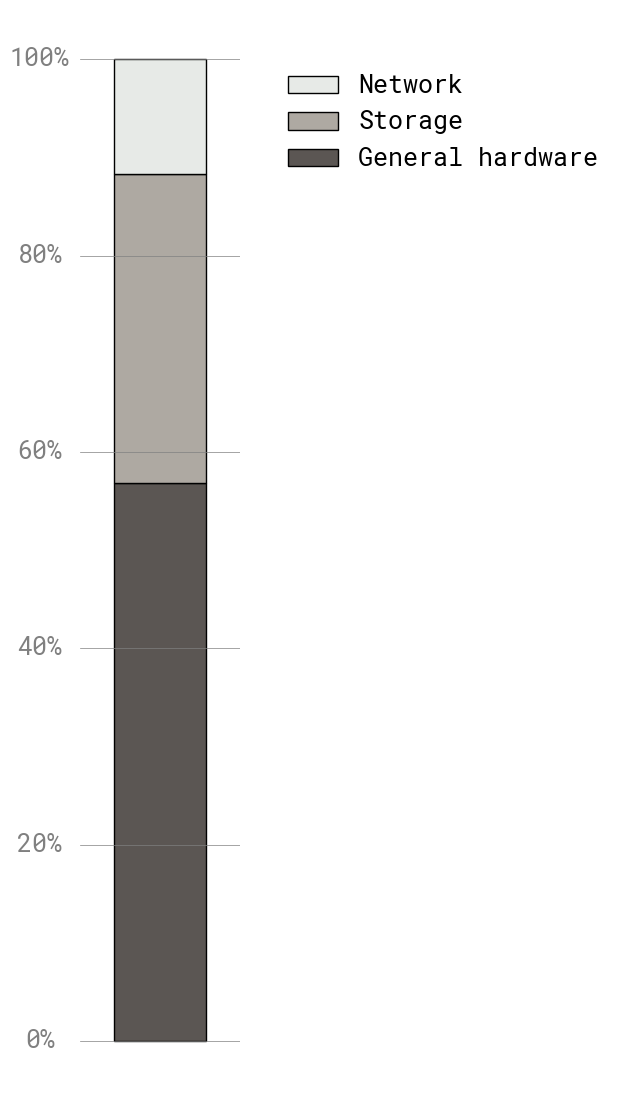

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Data
topics = [
    "Storage",
    "Network",
    "General hardware"
]

counts = [67, 25, 121]

# Create a DataFrame
df = pd.DataFrame({
    'Topic': topics,
    'Count': counts
})

# Normalize the counts to percentages
total = sum(df['Count'])
df['Percentage'] = (df['Count'] / total) * 100

# Sort the DataFrame by 'Count' in descending order
df = df.sort_values(by='Count', ascending=False).reset_index(drop=True)

# Initialize the plot
fig, ax = plt.subplots(figsize=(4, 12))

# Add a light grey grid in the background
ax.set_facecolor('lightgrey')
ax.grid(which='major', axis='y', linestyle='--', color='white')

# Define colors and hatches
colors = ['#5b5653', '#aea9a2', '#e7eae7']
hatches = [None, None, None]

# Plotting the single bar with segments
bottom = 0.01
for i, (percentage, color, hatch) in enumerate(zip(df['Percentage'], colors, hatches)):
    ax.bar(['AI pipeline'], percentage, bottom=bottom, color=color, edgecolor='black', hatch=hatch)
    bottom += percentage

# Adding horizontal lines at every 20%
for i in range(0, 101, 20):
    ax.axhline(y=i, color='grey', linestyle='-', linewidth=0.5)
    ax.text(-1.05, i, f'{i}%', ha='center', va='center', color='grey', fontsize=18, fontproperties=font_prop)  # Adding the percentage labels

ax.set_xlim(-0.7, 0.7)
legend_labels = df['Topic'][::-1]  # Reverse the order of labels
legend_colors = colors[:len(df)][::-1]  # Reverse the order of colors
legend_hatches = hatches[:len(df)][::-1] 

# Create custom legend handles
handles = []
for color, hatch, label in zip(legend_colors, legend_hatches, legend_labels):
    patch = plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black', hatch=hatch, label=label)
    handles.append(patch)
legend=ax.legend(handles=handles, loc='upper right', bbox_to_anchor=(3.3, 0.95), borderaxespad=0, frameon=False, fontsize=18)
for text in legend.get_texts():
    text.set_fontproperties(font_prop)
# Adding grid and labels
ax.set_yticks(range(0, 101, 20))
ax.set_yticklabels([f'{i}%' for i in range(0, 101, 20)], fontproperties=font_prop)

# Removing axes for cleaner look
ax.axis('off')

# Adjusting the plot layout to avoid overlap
plt.subplots_adjust(left=0.35, right=0.75, top=0.95, bottom=0.05)

# Display the plot
plt.show()


In [28]:
desired_topic = 6  # replace with your desired topic number
import textwrap
# Extract documents for the desired topic
documents_for_desired_topic = [doc for doc, topic in zip(abstracts, topics) if topic == desired_topic]

print(len(documents_for_desired_topic))

print(f"Documents for topic {desired_topic}:")
for doc in documents_for_desired_topic:
    wrapped_doc = textwrap.fill(doc, width=80)
    print(wrapped_doc)
    print("\n" + "="*80 + "\n") 

25
Documents for topic 6:
application of a switchable data network for real time and non-real time
communicationthe invention relates to a system and method for the control of a
first station  in a switched data network  by a second station  in the switched
data network , the communication between stations of the switched data network
taking place via one or more point-to-point connections in transmission cycles
which are synchronous with one another; for the transmission of a reference
value from a first station  of a switched data network  to a second station  of
the switched data network , the communication between stations of the switched
data network  taking place via one or more point-to-point connections in
transmission cycles which are synchronous with one another; for the transmission
of input values and output values between an input/output station  and a control
unit  via a switched data network ; for the transmission of a data telegram with
applications data via a switched 

In [31]:
pd.set_option('display.max_columns', None)
pd.reset_option('display.max_colwidth', None)
patents_text[patents_text.title == "network switch circuitry supporting multiple different link-layer protocols"]

,country,number,kind,publication_date_EPO,title_de_EPO,title_en_EPO,title_fr_EPO,abstract_de_EPO,abstract_en_EPO,abstract_fr_EPO,applicant_names,applicant_countries,inventor_EPO,inventor_countries,ipc_codes_EPO,cpc_codes_EPO,family_id,application_number,claims_de,claims_en,claims_fr,description_de,description_en,description_fr,publication_number_EPO,publication_date_google,filing_date,inventor_google,abstract_en_google,title_en_google,abstract_fr_google,title_fr_google,abstract_de_google,title_de_google,assignee_name,assignee_country,cpc_codes_google,ipc_codes_google,publication_number_GPO,title_GPO,assignee_name_GPO,inventor_name_GPO,priority_date_GPO,filing_date_GPO,publication_date_GPO,grant_date_GPO,lang_title_en_EPO,lang_title_en_google,translated_abstract,translated_descr,translated_claims,abstract,description,claims,title_en_EPO_lang,title_en_google_lang,title,SofAI,AIforS,text
17421,EP,3823245,A1,20210519,SCHALTUNG FÜR EINEN NETZWERK-SWITCH MIT UNTERS...,network switch circuitry supporting multiple d...,CIRCUIT DE COMMUTATEUR DE RÉSEAU PRENANT EN CH...,NaN,\n,NaN,['INTEL Corporation'],['US'],"['BERNAT, Francesc Guim, ', 'CUSTODIO, Evan, '...","['US', 'US', 'US', 'US', 'US', 'US', 'US', 'US...","['H04L 45/ 28 A I', 'H04L 49/ ...","['B25J 15/0014', 'G06F 1/183', 'G06F 1/20', 'G...",65037934,20217841,NaN,['1. Network switch circuitry for use in assoc...,NaN,NaN,"['CROSS-REFERENCE TO RELATED APPLICATIONS', 'T...",NaN,EP-3823245-A1,20210519.0,20180828.0,"[BERNAT, FRANCESC GUIM,CUSTODIO, EVAN,BALLE, S...",network switch circuitry for use with a physic...,network switch circuitry supporting multiple d...,NaN,Circuit de commutateur de réseau prenant en ch...,NaN,Schaltung für einen netzwerk-switch mit unters...,INTEL CORP,US,"['H04L47/83', 'G06F9/5088', 'H04L41/0896', 'H0...","['H04L49/111', 'H04L45/28']",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,en,NaN,NaN,NaN,network switch circuitry for use with a physic...,"['cross-reference to related applications', 't...",['. network switch circuitry for use in associ...,en,en,network switch circuitry supporting multiple d...,1.0,0.0,network switch circuitry supporting multiple d...


In [ ]:
# Run the visualization with the original embeddings
topic_model.visualize_document_datamap(abstracts, embeddings=embeddings_specter, custom_labels=True)

# with the reduced embeddings
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.05, metric='cosine').fit_transform(embeddings_specter)
topic_model.visualize_document_datamap(abstracts, reduced_embeddings=reduced_embeddings, custom_labels=True)


In [ ]:
timestamps = pd.to_datetime(sofai['publication_date_EPO'], format='%Y%m%d').to_list()
topics_over_time = topic_model.topics_over_time(abstracts, timestamps, nr_bins=18)

topic_model.visualize_topics_over_time(topics_over_time, custom_labels=True)

## larger SofAI

In [88]:
sofai_large = patents_text[patents_text['SofAI'] == 1]

def extract_first_300_words(text):
    words = re.findall(r'\b\w+\b', text)
    return ' '.join(words[:300])
abstracts_large = sofai_large['title'] + sofai_large['abstract'] + sofai_large["description"].fillna('').apply(extract_first_300_words)
abstracts_large = abstracts_large.apply(str).tolist()

In [89]:
embeddings_specter_sofai_large = np.load('embeddings_specter_sofai_large.npy')

In [50]:
len(embeddings_specter_sofai_large)

3048

In [105]:
vectorizer_model2 = CountVectorizer(stop_words=stopwords_list, ngram_range=(1, 2))

#zeroshot_topic_list = ["data acquisition and sensor technology", "data storage", "algorithmic design, layers, model", "computing hardware", "deployment, edge and cloud"]
#zeroshot_topic_list = ["sensor data collection, environmental monitoring, IoT sensors", "data storage, data warehouses, data management, data center, uninterruptible power supply, power factor correction, power transfer", "algorithmic design, model architecture, layer, deep learning, weights", "computing hardware, processors, GPU, cooling, memory", "power management, battery", "network infrastructure, bandwidth, data transmission", "deployment, edge and cloud"]
zeroshot_topic_list = [
    "sensor, data collection, environmental monitoring, IoT sensors", # data collection
    "storage, storage area network, network-attached storage, distributed file system" , # data storage
    "data center, uninterruptible power supply, power distribution unit, generator, cooling, ventilation, pump, chiller, low-precision hardware", # general data center infrastructure
    "algorithmic design, weights, pruned, parallelism, model compression", # model development
    "computation, specialized acceleration, application-specific integrated circuits, field-programmable gate array", # compute
    "network infrastructure, bandwidth, data transmission, routers, cable, switch, firewall, connectivity", # network
    "platform for optimization techniques, framework, library"
    #"deployment, edge and cloud, inference, inference prediction, production use case" # deployment
    ]

           
topic_model = BERTopic(embedding_model=embedding_model_specter, 
    min_topic_size=80,
    zeroshot_topic_list=zeroshot_topic_list,
    zeroshot_min_similarity=.56,
    vectorizer_model = vectorizer_model2,
    representation_model= representation_model
    #ctfidf_model=ctfidf_model
    )

# Train model
topics, probs = topic_model.fit_transform(abstracts_large, embeddings_specter_sofai_large)

# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,MMR,Representative_Docs
0,0,2110,"data center, uninterruptible power supply, pow...","[power, voltage, input, circuit, output, dc, c...","[power converter, power supply, ac power, dc p...","[power, voltage, input, circuit, output, dc, c...",[power supply apparatusan electronic apparatus...
1,1,239,"computation, specialized acceleration, applica...","[processing, data, neural, neural network, net...","[chip, integrated circuit, neural networks, ha...","[processing, data, neural, neural network, net...",[artificial intelligence processor and method ...
2,2,238,"network infrastructure, bandwidth, data transm...","[network, data, communication, device, transmi...","[ethernet, wireless, device, devices, configur...","[network, data, communication, device, transmi...","[signal encoding method and apparatus, united ..."
3,3,178,"sensor, data collection, environmental monitor...","[data, model, device, learning, processing, im...","[wireless, technology, power consumption, devi...","[data, model, device, learning, processing, im...",[systems and methods for preventing machine le...
4,4,151,"storage, storage area network, network-attache...","[memory, data, storage, device, information, p...","[memory device, memory devices, storage device...","[memory, data, storage, device, information, p...",[integrated circuit i/o using a high performan...
5,5,80,"algorithmic design, weights, pruned, paralleli...","[graphics, data, processing, learning, machine...","[parallel graphics, graphics processors, graph...","[graphics, data, processing, learning, machine...",[compute optimizations for low precision machi...
6,6,52,"platform for optimization techniques, framewor...","[data, set, powertrain, hotspot, set applicati...","[component placement, resource scheduling, spe...","[data, set, powertrain, hotspot, set applicati...",[powertrain controllerthe present invention re...


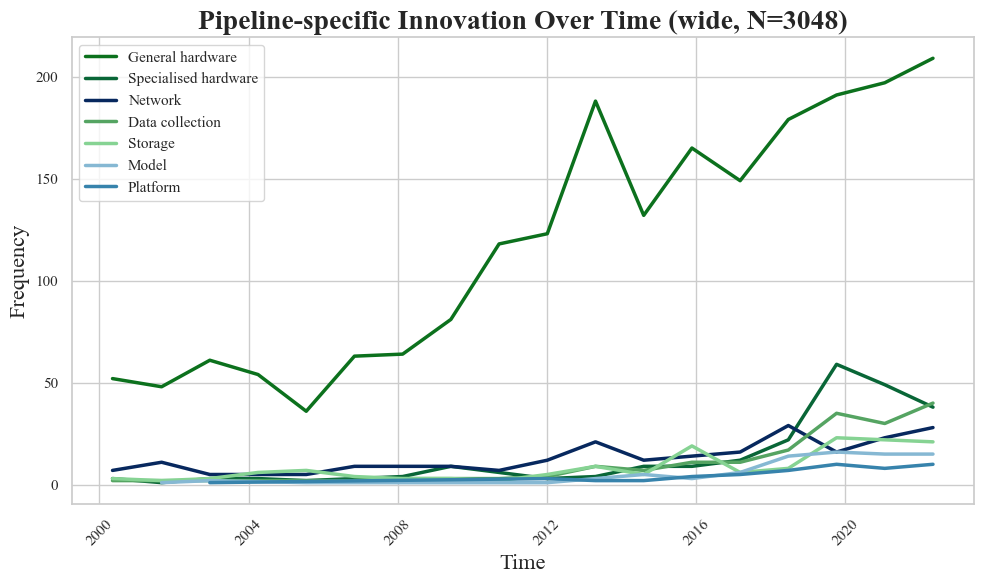

In [107]:
timestamps = pd.to_datetime(sofai_large['publication_date_EPO'], format='%Y%m%d').to_list()
topics_over_time = topic_model.topics_over_time(abstracts_large, timestamps, nr_bins=18)

# Setting the topic labels
topic_labels = { 0: "General hardware", 1: "Specialised hardware", 2: "Network", 3: "Data collection", 4: "Storage", 5: "Model", 6: "Platform"}

## Pivot the DataFrame to get the topics as columns
topics_pivot = topics_over_time.pivot(index='Timestamp', columns='Topic', values='Frequency')

# Set the style for the plot
sns.set(style="whitegrid")

# Create a color palette with shades of Seagreen
colours = {
    1: '#096637',
    0: '#0c711d',
    3: '#55a462',
    4: '#86d393',
    5: '#86b8d3',
    6: '#3783ac',
    2: '#07285e'  
}
 # 7 colors for the 7 topics

# Plotting with Seaborn
plt.figure(figsize=(10, 6))

# Loop through each topic and plot it
for idx, topic in enumerate(topics_pivot.columns):
    sns.lineplot(data=topics_pivot, x=topics_pivot.index, y=topic, label=topic_labels[topic], color=colours[idx], linewidth=2.5)

# Customize the plot for a scientific paper look
plt.title('Pipeline-specific Innovation Over Time (wide, N=3048)', fontsize=20, fontweight='bold', fontname='Times New Roman')
plt.xlabel('Time', fontsize=16, fontname='Times New Roman')
plt.ylabel('Frequency', fontsize=16, fontname='Times New Roman')
plt.xticks(rotation=45, fontname='Times New Roman')
plt.yticks(fontname='Times New Roman')
plt.legend(fontsize='16', prop={'family': 'Times New Roman'})
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

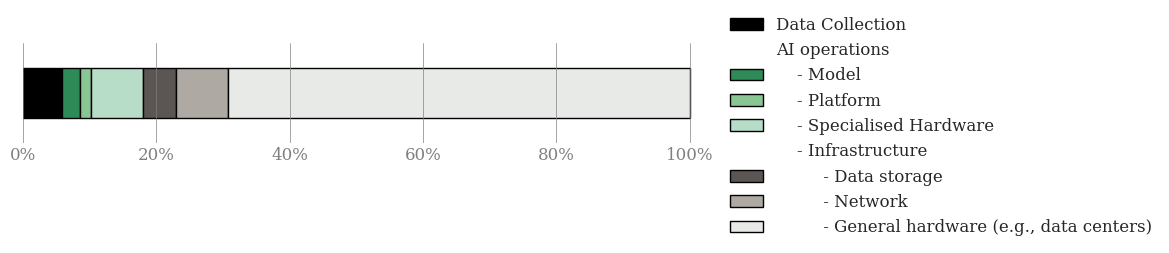

In [184]:

['#5b5653', '#aea9a2', '#e7eae7']

# Data
topics = [
    "Data collection",
    "Model",
    "Platform",
    "Specialised Hardware",
    "Data storage",
    "Network",
    "General hardware (e.g., data centers)"
]


counts = [178, 80, 52, 239, 151, 238, 2110]

# Create a DataFrame
df = pd.DataFrame({
    'Topic': topics,
    'Count': counts
})

# Normalize the counts to percentages
total = sum(df['Count'])
df['Percentage'] = (df['Count'] / total) * 100

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 2))

# Add a light grey grid in the background
ax.set_facecolor('lightgrey')
ax.grid(which='major', axis='x', linestyle='--', color='white')

# Define colors and hatches
colors = ["black", '#2e8b57','#8ac594','#b7ddc8', '#5b5653', '#aea9a2', '#e7eae7']
hatches = [None, None, None, None, None, None, None]

# Plotting the single bar with segments
left = 0
for i, (percentage, color, hatch) in enumerate(zip(df['Percentage'], colors, hatches)):
    ax.barh(['AI pipeline'], percentage, left=left, color=color, edgecolor='black', hatch=hatch)
    left += percentage

# Adding vertical lines at every 20%
for i in range(0, 101, 20):
    ax.axvline(x=i, color='grey', linestyle='-', linewidth=0.5)
    ax.text(i, -1, f'{i}%', ha='center', va='center', color='grey', fontsize=12)  # Adding the percentage labels

ax.set_ylim(-0.8, 0.8)
# Custom legend structure
legend_labels = [
    "Data Collection",
    "AI operations",
    "Model",
    "Platform",
    "Specialised Hardware",
    "Infrastructure",
    "Data storage",
    "Network",
    "General hardware (e.g., data centers)"
]

legend_colors = ['black', None, '#2e8b57', '#8ac594', '#b7ddc8', None, '#5b5653', '#aea9a2', '#e7eae7']
legend_hatches = [None, None, None, None, None, None, None, None, None]

# Create custom legend handles
handles = []
for color, hatch, label in zip(legend_colors, legend_hatches, legend_labels):
    if color is not None:
        patch = plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black', hatch=hatch, label=label)
    else:
        patch = plt.Rectangle((0, 0), 1, 1, facecolor='none', edgecolor='none', hatch=None, label=label)
    handles.append(patch)

# Create the legend with grouped handles
from matplotlib.legend_handler import HandlerTuple

# Group the handles for AI operations and Infrastructure with an indent
grouped_handles = [
    (handles[0],),  # Data Collection
    (handles[1], handles[2], handles[3], handles[4]),  # AI operations and its topics
    (handles[5], handles[6], handles[7], handles[8]),  # Infrastructure and its topics
]

# Adjust the labels with indentation
legend_labels_grouped = [
    "Data Collection",
    "AI operations",
    "    - Model",
    "    - Platform",
    "    - Specialised Hardware",
    "    - Infrastructure",
    "         - Data storage",
    "         - Network",
    "         - General hardware (e.g., data centers)"
]

# Flatten the handles list for creating the legend
flat_handles = [item for sublist in grouped_handles for item in sublist]

# Create the legend
ax.legend(flat_handles, legend_labels_grouped, loc='lower left', bbox_to_anchor=(1, -1), borderaxespad=0, frameon=False, fontsize=12)

# Adding grid and labels
ax.set_xticks(range(0, 101, 20))
ax.set_xticklabels([f'{i}%' for i in range(0, 101, 20)])
ax.xaxis.tick_top()

# Removing axes for cleaner look
ax.axis('off')

# Adjusting the plot layout to avoid overlap
plt.subplots_adjust(left=0.05, right=0.75, top=0.85, bottom=0.35)

# Display the plot
plt.show()





In [ ]:
178, 80, 52, 239, 151, 238, 2110
1465

In [54]:
151+238+2110

2499

In [55]:
178/3048, 80/(3048-187), 52/(3048-187), 239/(3048-187), 151/2499, 238/2499, 2110/2499

(0.0583989501312336,
 0.027962250961202376,
 0.018175463124781546,
 0.0835372247465921,
 0.06042416966786715,
 0.09523809523809523,
 0.8443377350940376)

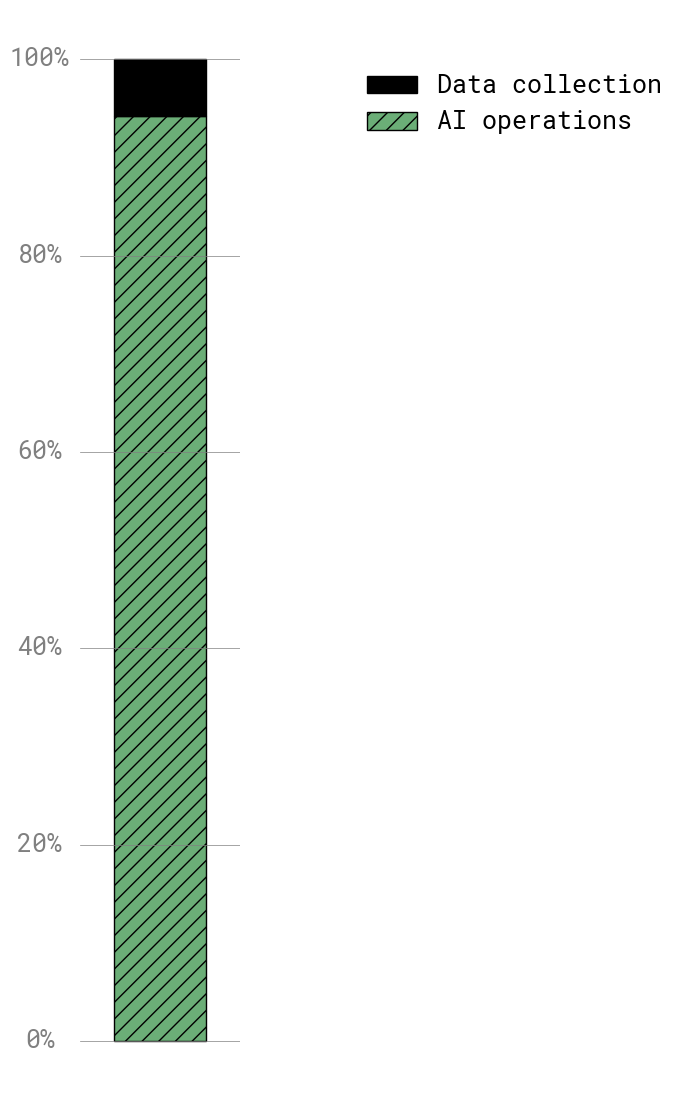

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.font_manager as font_manager
# Ensure LaTeX is not used
plt.rcParams['text.usetex'] = False
font_path = '/Library/Fonts/RobotoMono-Regular.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=18)


# Data
topics = [
    "Data collection",
    "AI operations"
]


counts = [178, 3048-178]

# Create a DataFrame
df = pd.DataFrame({
    'Topic': topics,
    'Count': counts
})

# Normalize the counts to percentages
total = sum(df['Count'])
df['Percentage'] = (df['Count'] / total) * 100

# Sort the DataFrame by 'Count' in descending order
df = df.sort_values(by='Count', ascending=False).reset_index(drop=True)

# Initialize the plot
fig, ax = plt.subplots(figsize=(4, 12))

# Add a light grey grid in the background
ax.set_facecolor('lightgrey')
ax.grid(which='major', axis='y', linestyle='--', color='white')

# Define colors and hatches
colors = ['#6bae77', '#000000']
hatches = ['//', None]

# Plotting the single bar with segments
bottom = 0.01
for i, (percentage, color, hatch) in enumerate(zip(df['Percentage'], colors, hatches)):
    ax.bar(['AI pipeline'], percentage, bottom=bottom, color=color, edgecolor='black', hatch=hatch)
    bottom += percentage

# Adding horizontal lines at every 20%
for i in range(0, 101, 20):
    ax.axhline(y=i, color='grey', linestyle='-', linewidth=0.5)
    ax.text(-1.05, i, f'{i}%', ha='center', va='center', color='grey', fontsize=18, fontproperties=font_prop)  # Adding the percentage labels

ax.set_xlim(-0.7, 0.7)
legend_labels = df['Topic'][::-1]  # Reverse the order of labels
legend_colors = colors[:len(df)][::-1]  # Reverse the order of colors
legend_hatches = hatches[:len(df)][::-1] 

# Create custom legend handles
handles = []
for color, hatch, label in zip(legend_colors, legend_hatches, legend_labels):
    patch = plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black', hatch=hatch, label=label)
    handles.append(patch)
legend = ax.legend(handles=handles, loc='upper right', bbox_to_anchor=(3.7, 0.95), borderaxespad=0, frameon=False, fontsize=18)
for text in legend.get_texts():
    text.set_fontproperties(font_prop)
# Adding grid and labels
ax.set_yticks(range(0, 101, 20))
ax.set_yticklabels([f'{i}%' for i in range(0, 101, 20)], fontproperties=font_prop)

# Removing axes for cleaner look
ax.axis('off')

# Adjusting the plot layout to avoid overlap
plt.subplots_adjust(left=0.35, right=0.75, top=0.95, bottom=0.05)

# Display the plot
plt.show()

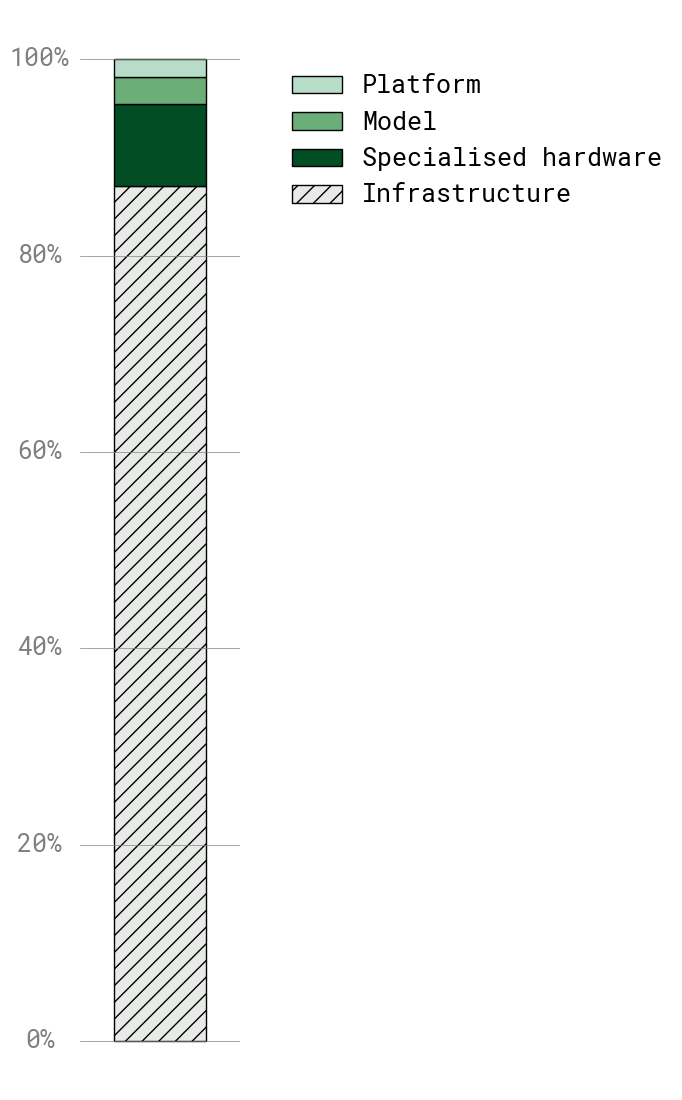

In [46]:
# Ensure LaTeX is not used
plt.rcParams['text.usetex'] = False
font_path = '/Library/Fonts/RobotoMono-Regular.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=18)


# Data
topics = [
    "Model",
    "Platform",
    "Specialised hardware",
    "Infrastructure"
]


counts = [80, 52, 239, 151+ 238+ 2110]

# Create a DataFrame
df = pd.DataFrame({
    'Topic': topics,
    'Count': counts
})

# Normalize the counts to percentages
total = sum(df['Count'])
df['Percentage'] = (df['Count'] / total) * 100

# Sort the DataFrame by 'Count' in descending order
df = df.sort_values(by='Count', ascending=False).reset_index(drop=True)


# Initialize the plot
fig, ax = plt.subplots(figsize=(4, 12))

# Add a light grey grid in the background
ax.set_facecolor('lightgrey')
ax.grid(which='major', axis='y', linestyle='--', color='white')

# Define colors and hatches
colors = ['#e7eae7',
          '#024d23', 
          '#6bae77',
          '#b7ddc8'
          ]
hatches = ['//', None, None, None]

# Plotting the single bar with segments
bottom = 0.01
for i, (percentage, color, hatch) in enumerate(zip(df['Percentage'], colors, hatches)):
    ax.bar(['AI pipeline'], percentage, bottom=bottom, color=color, edgecolor='black', hatch=hatch)
    bottom += percentage

# Adding horizontal lines at every 20%
for i in range(0, 101, 20):
    ax.axhline(y=i, color='grey', linestyle='-', linewidth=0.5)
    ax.text(-1.05, i, f'{i}%', ha='center', va='center', color='grey', fontsize=18, fontproperties=font_prop)  # Adding the percentage labels

ax.set_xlim(-0.7, 0.7)
legend_labels = df['Topic'][::-1]  # Reverse the order of labels
legend_colors = colors[:len(df)][::-1]  # Reverse the order of colors
legend_hatches = hatches[:len(df)][::-1] 

# Create custom legend handles
handles = []
for color, hatch, label in zip(legend_colors, legend_hatches, legend_labels):
    patch = plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black', hatch=hatch, label=label)
    handles.append(patch)
legend=ax.legend(handles=handles, loc='upper right', bbox_to_anchor=(3.7, 0.95), borderaxespad=0, frameon=False, fontsize=18)
for text in legend.get_texts():
    text.set_fontproperties(font_prop)
# Adding grid and labels
ax.set_yticks(range(0, 101, 20))
ax.set_yticklabels([f'{i}%' for i in range(0, 101, 20)], fontproperties=font_prop)

# Removing axes for cleaner look
ax.axis('off')

# Adjusting the plot layout to avoid overlap
plt.subplots_adjust(left=0.35, right=0.75, top=0.95, bottom=0.05)

# Display the plot
plt.show()



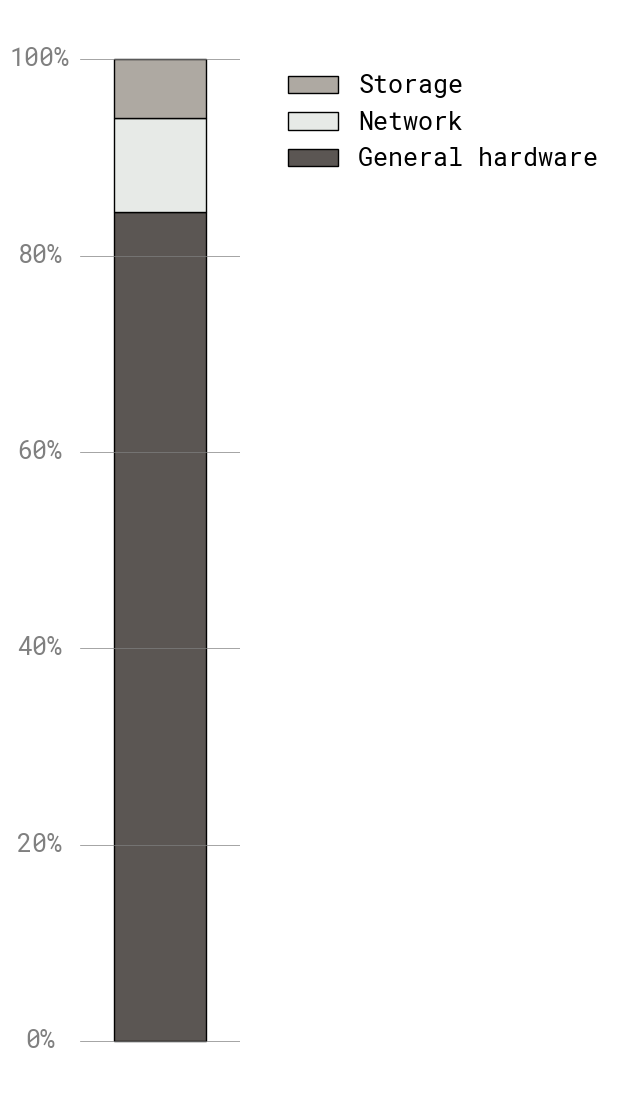

In [45]:
import matplotlib.pyplot as plt
import pandas as pd

# Data
topics = [
    "Storage",
    "Network",
    "General hardware"
]

counts = [151, 238, 2110]

# Create a DataFrame
df = pd.DataFrame({
    'Topic': topics,
    'Count': counts
})

# Normalize the counts to percentages
total = sum(df['Count'])
df['Percentage'] = (df['Count'] / total) * 100

# Sort the DataFrame by 'Count' in descending order
df = df.sort_values(by='Count', ascending=False).reset_index(drop=True)

# Initialize the plot
fig, ax = plt.subplots(figsize=(4, 12))

# Add a light grey grid in the background
ax.set_facecolor('lightgrey')
ax.grid(which='major', axis='y', linestyle='--', color='white')

# Define colors and hatches
colors = ['#5b5653', '#e7eae7', '#aea9a2']
hatches = [None, None, None]

# Plotting the single bar with segments
bottom = 0.01
for i, (percentage, color, hatch) in enumerate(zip(df['Percentage'], colors, hatches)):
    ax.bar(['AI pipeline'], percentage, bottom=bottom, color=color, edgecolor='black', hatch=hatch)
    bottom += percentage

# Adding horizontal lines at every 20%
for i in range(0, 101, 20):
    ax.axhline(y=i, color='grey', linestyle='-', linewidth=0.5)
    ax.text(-1.05, i, f'{i}%', ha='center', va='center', color='grey', fontsize=18, fontproperties=font_prop)  # Adding the percentage labels

ax.set_xlim(-0.7, 0.7)
legend_labels = df['Topic'][::-1]  # Reverse the order of labels
legend_colors = colors[:len(df)][::-1]  # Reverse the order of colors
legend_hatches = hatches[:len(df)][::-1] 

# Create custom legend handles
handles = []
for color, hatch, label in zip(legend_colors, legend_hatches, legend_labels):
    patch = plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black', hatch=hatch, label=label)
    handles.append(patch)
legend=ax.legend(handles=handles, loc='upper right', bbox_to_anchor=(3.3, 0.95), borderaxespad=0, frameon=False, fontsize=18)
for text in legend.get_texts():
    text.set_fontproperties(font_prop)
# Adding grid and labels
ax.set_yticks(range(0, 101, 20))
ax.set_yticklabels([f'{i}%' for i in range(0, 101, 20)], fontproperties=font_prop)

# Removing axes for cleaner look
ax.axis('off')

# Adjusting the plot layout to avoid overlap
plt.subplots_adjust(left=0.35, right=0.75, top=0.95, bottom=0.05)

# Display the plot
plt.show()


In [60]:
timestamps = pd.to_datetime(sofai['publication_date_EPO'], format='%Y%m%d').to_list()
topics_over_time = topic_model.topics_over_time(abstracts, timestamps, nr_bins=20)
topic_model.visualize_topics_over_time(topics_over_time)

In [64]:
topics_over_time = topic_model.topics_over_time(abstracts, timestamps, nr_bins=20)

In [65]:
topic_model.visualize_topics_over_time(topics_over_time)